<a href="https://colab.research.google.com/github/KhaSab5292/DS-Unit-2-Kaggle-Challenge/blob/master/Copy_of_assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [92]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [93]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

## **train/validate/test split**

In [94]:
train, val = train_test_split(train, stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((44550, 41), (14850, 41), (14358, 40))

# **Wrangle**

In [95]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [96]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,44550.000000,44550.000000,44550.000000,44550.000000,4.455000e+04,44550.000000,44550.000000,44550.000000,44550.000000,44550.000000
mean,37014.537755,324.898325,669.616094,34.080309,-5.715456e+00,0.485140,15.252391,5.607250,179.684085,1302.070011
std,21402.267757,3281.228067,693.047465,6.558393,2.941760e+00,13.683636,17.541883,9.597167,462.207597,951.166321
min,0.000000,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18449.250000,0.000000,0.000000,33.090018,-8.545223e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,36966.500000,0.000000,372.000000,34.912797,-5.036199e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55374.250000,25.000000,1320.000000,37.171335,-3.328885e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.344301,-2.000000e-08,1776.000000,99.000000,80.000000,15300.000000,2013.000000


In [97]:
train.describe(exclude = 'number')

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,44550,41815,41804,44550,44550,44284,44550,44550,44550,42082,44550,41626,23413,42257,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550
unique,348,1670,1868,28980,9,16666,21,124,2076,2,1,12,2519,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Majengo,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,443,6856,13101,2718,7577,389,4009,1883,237,38275,44550,27659,521,29099,20085,20085,20085,30453,39428,19035,19035,38044,38044,24909,24909,12760,12760,34365,21356,25910,24194


In [98]:
train['water_quality'].value_counts()

soft                  38044
salty                  3670
unknown                1409
milky                   611
coloured                380
salty abandoned         269
fluoride                153
fluoride abandoned       14
Name: water_quality, dtype: int64

In [99]:
train['quality_group'].value_counts()

good        38044
salty        3939
unknown      1409
milky         611
colored       380
fluoride      167
Name: quality_group, dtype: int64

In [100]:
train['quantity'].value_counts()

enough          24909
insufficient    11376
dry              4628
seasonal         3039
unknown           598
Name: quantity, dtype: int64

In [101]:
train['quantity_group'].value_counts()

enough          24909
insufficient    11376
dry              4628
seasonal         3039
unknown           598
Name: quantity_group, dtype: int64

In [102]:
train['management'].value_counts()

vwc                 30453
wug                  4863
water board          2181
wua                  1931
private operator     1466
parastatal           1295
water authority       688
other                 630
company               494
unknown               421
other - school         70
trust                  58
Name: management, dtype: int64

In [103]:
train['management_group'].value_counts()

user-group    39428
commercial     2706
parastatal     1295
other           700
unknown         421
Name: management_group, dtype: int64

In [104]:
train['extraction_type'].value_counts()	

gravity                      20085
nira/tanira                   6123
other                         4863
submersible                   3530
swn 80                        2770
mono                          2116
india mark ii                 1801
afridev                       1346
ksb                           1065
other - rope pump              329
other - swn 81                 171
windmill                        88
india mark iii                  70
cemo                            66
other - play pump               63
walimi                          40
climax                          23
other - mkulima/shinyanga        1
Name: extraction_type, dtype: int64

In [105]:
train['extraction_type_group'].value_counts()		

gravity            20085
nira/tanira         6123
other               4863
submersible         4595
swn 80              2770
mono                2116
india mark ii       1801
afridev             1346
rope pump            329
other handpump       275
other motorpump       89
wind-powered          88
india mark iii        70
Name: extraction_type_group, dtype: int64

In [106]:
train['extraction_type_class'].value_counts()

gravity         20085
handpump        12385
other            4863
submersible      4595
motorpump        2205
rope pump         329
wind-powered       88
Name: extraction_type_class, dtype: int64

In [107]:
train['payment'].value_counts()

never pay                19035
pay per bucket            6694
pay monthly               6242
unknown                   6111
pay when scheme fails     2898
pay annually              2751
other                      819
Name: payment, dtype: int64

In [108]:
train['payment_type'].value_counts()

never pay     19035
per bucket     6694
monthly        6242
unknown        6111
on failure     2898
annually       2751
other           819
Name: payment_type, dtype: int64

In [109]:
train['source'].value_counts()	

spring                  12760
shallow well            12686
machine dbh              8256
river                    7216
rainwater harvesting     1734
hand dtw                  663
lake                      532
dam                       482
other                     165
unknown                    56
Name: source, dtype: int64

In [110]:
train['source_type'].value_counts()

spring                  12760
shallow well            12686
borehole                 8919
river/lake               7748
rainwater harvesting     1734
dam                       482
other                     221
Name: source_type, dtype: int64

In [111]:
train['source_class'].value_counts()

groundwater    34365
surface         9964
unknown          221
Name: source_class, dtype: int64

In [112]:
train['waterpoint_type'].value_counts()	

communal standpipe             21356
hand pump                      13162
other                           4794
communal standpipe multiple     4554
improved spring                  596
cattle trough                     84
dam                                4
Name: waterpoint_type, dtype: int64

In [113]:
train['waterpoint_type_group'].value_counts()

communal standpipe    25910
hand pump             13162
other                  4794
improved spring         596
cattle trough            84
dam                       4
Name: waterpoint_type_group, dtype: int64

In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # replace very small values with zeros.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # drop duplicate columns and rename certain columns,
    X = X.drop(columns = ['quantity_group', 'water_quality', 'extraction_type', 
                          'extraction_type_group', 'payment', 'source', 'waterpoint_type'])
    X['quality_group'] = X['quality_group'].str.replace('good', 'soft')
    X['payment_type'] = X['payment_type'].str.replace('on failure', 'upon failure')
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [115]:
train.shape, val.shape, test.shape

((44550, 34), (14850, 34), (14358, 33))

# **Select features and target**

In [116]:
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include = 'number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude = 'number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type_class', 'management', 'management_group', 'payment_type', 'quality_group', 'quantity', 'source_type', 'source_class', 'waterpoint_type_group']


In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]



# **Pipeline and regressionfit**

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names = True), 
    SimpleImputer(strategy = 'mean'), 
    StandardScaler(), 
    LogisticRegression(multi_class = 'auto', solver = 'lbfgs', n_jobs = -1))


In [119]:
# Fit on train
pipeline.fit(X_train, y_train)

# Score on train and val
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Train Accuracy 0.7294500561167228
Validation Accuracy 0.7290909090909091


# **Pipeline and Decision tree fit**

In [0]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names = True), 
    SimpleImputer(strategy = 'mean'), 
    DecisionTreeClassifier(random_state = 42))

In [121]:
# Fit on train
pipeline.fit(X_train, y_train)

# Score on train, val
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Train Accuracy 0.9947250280583614
Validation Accuracy 0.7538047138047138


# **ploting feature importances**

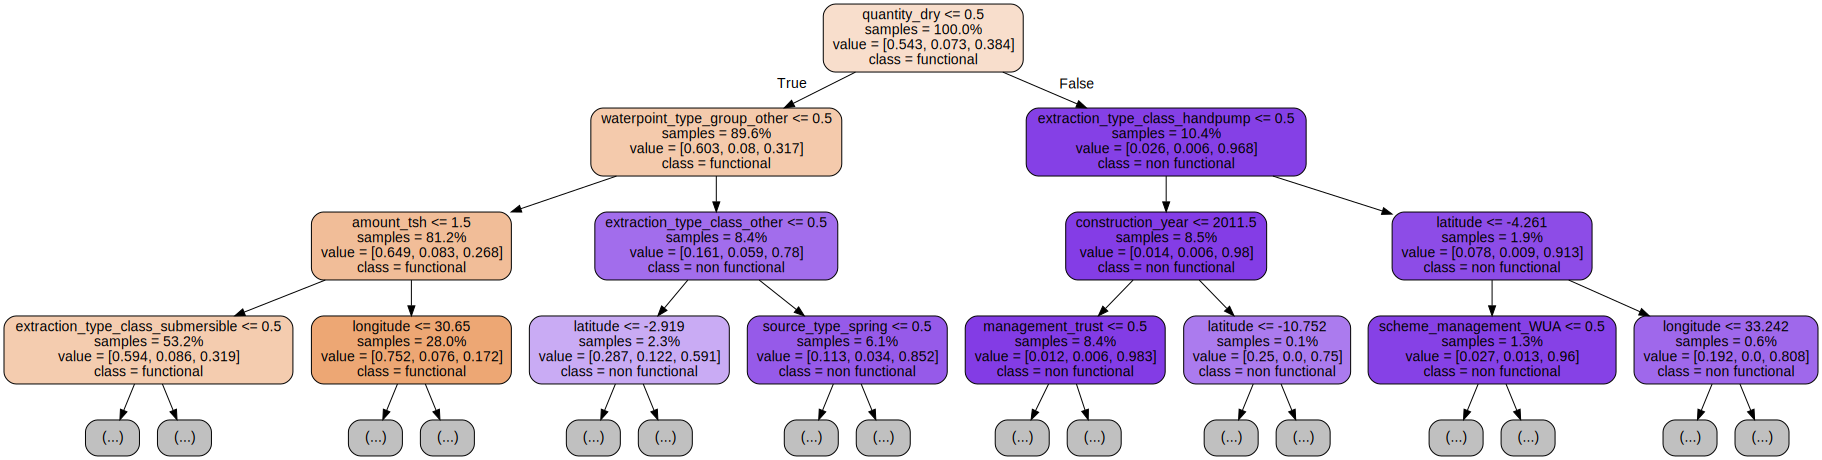

In [127]:
import graphviz
from sklearn.tree import export_graphviz

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file = None, 
                           max_depth = 3, 
                           feature_names = encoded_columns,
                           class_names = model.classes_, 
                           impurity = False, 
                           filled = True, 
                           proportion = True, 
                           rounded = True)   
display(graphviz.Source(dot_data))

# **Kaggle submission**

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('My_submission.csv', index = False)

In [0]:
from google.colab import files
files.download('My_submission.csv')